# Model 1: Basic Regression for Predicting MLB Scores

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
import datetime
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
#get parent directory:
import os
parentDirectory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append('/Users/efriedlander/Dropbox/SportsBetting/mlb-predict')
from src.data import bbref_scrape
from src.data import clean_data

## Data Preparation

First scrape, import, and parse the data scraped from baseball-reference. We will save the parsed data so we don't have to repeat that step every time we run the notebook.

In [2]:
# start19 = datetime.datetime(2019, 1, 1)
# end19 = datetime.datetime(2019, 12, 31)
# start18 = datetime.datetime(2018, 1, 1)
# end18 = datetime.datetime(2018, 12, 31)
# start17 = datetime.datetime(2017, 1, 1)
# end17 = datetime.datetime(2017, 12, 31)

In [3]:
# links19 = bbref_scrape.get_box_score_links('ALL', start19, end19)
# boxscores19 = bbref_scrape.get_box_scores(links19)
# pkl.dump(boxscores19, open(os.path.join(parentDirectory, 'data', 'boxscores2019.p'), 'wb'))

In [4]:
# links18 = bbref_scrape.get_box_score_links('ALL', start18, end18)
# boxscores18 = bbref_scrape.get_box_scores(links18)
# pkl.dump(boxscores18, open(os.path.join(parentDirectory, 'data', 'boxscores2018.p'), 'wb'))

In [5]:
# links17 = bbref_scrape.get_box_score_links('ALL', start17, end17)
# boxscores17 = bbref_scrape.get_box_scores(links17)
# pkl.dump(boxscores17, open(os.path.join(parentDirectory, 'data', 'boxscores2017.p'), 'wb'))

In [6]:
# scores = pkl.load(open(os.path.join(parentDirectory, 'data', 'boxscores2019.p'), 'rb'))
# parsed_scores = bbref_scrape.parse_box_scores(scores)
# pkl.dump(parsed_scores, open(os.path.join(parentDirectory, 'data', 'parsedData2019.p'), 'wb'))

# scores = pkl.load(open(os.path.join(parentDirectory, 'data', 'boxscores2018.p'), 'rb'))
# parsed_scores = bbref_scrape.parse_box_scores(scores)
# pkl.dump(parsed_scores, open(os.path.join(parentDirectory, 'data', 'parsedData2018.p'), 'wb'))

# scores = pkl.load(open(os.path.join(parentDirectory, 'data', 'boxscores2017.p'), 'rb'))
# parsed_scores = bbref_scrape.parse_box_scores(scores)
# pkl.dump(parsed_scores, open(os.path.join(parentDirectory, 'data', 'parsedData2017.p'), 'wb'))

Load the parsed data and concatenate 2017, 2018, and 2019 data.

In [7]:
parsed19 = pkl.load(open(os.path.join(parentDirectory, 'data', 'parsedData2019.p'), 'rb'))

The parser outputs four dataframes. For now we will only concern ourselves with the game and team level data.

In [8]:
game_level = parsed19['Game']
team_level = parsed19['Team']

In [9]:
game_level.columns

Index(['GameID', 'AwayTeam', 'HomeTeam', 'DateTime', 'Attendance', 'Venue',
       'Duration', 'Details', 'AwayScore', 'HomeScore'],
      dtype='object')

In [10]:
team_level.columns

Index(['GameID', 'Team', 'GameNum', 'Wins', 'Losses', 'HomeAway', 'Inn1',
       'Inn2', 'Inn3', 'Inn4', 'Inn5', 'Inn6', 'Inn7', 'Inn8', 'Inn9', 'Runs',
       'Hits', 'Errors', 'AB', 'R', 'H', 'RBI', 'BB', 'SO', 'PA', 'BA', 'OBP',
       'SLG', 'OPS', 'Pit', 'Str', 'WPA', 'aLI', 'WPA+', 'WPA-', 'RE24', 'PO',
       'A', 'Starter', 'IP', 'H_P', 'R_P', 'ER', 'BB_P', 'SO_P', 'HR_P', 'ERA',
       'BF', 'Pit_P', 'Str_P', 'Ctct', 'StS', 'StL', 'GB', 'FB', 'LD', 'Unk',
       'GSc', 'IR', 'IS', 'WPA_P', 'aLI_P', 'RE24_P'],
      dtype='object')

For this first model we'll only consider a subset of the rows for each game. Let's extract the team variables that we'll be using and make sure they have the appropriate data types. In general, we're excluding any variables that are for single innings (`Inn1`,\ldots, `Inn9`), any of the data for pitching (with a _P suffice), any statistics that are linear combinations of the others (OPS), and some of the mroe advanced statistics such as WPA. We'll definitely look into adding these to the model in the future in order to improve our predictions.

In [11]:
team_data = team_level[['GameID', 'Team', 'GameNum', 'HomeAway', 'Runs', 'Hits', 'Errors', 'AB', 
                        'RBI', 'BB', 'SO', 'PA', 'OBP', 'SLG', 'Starter']].astype({'GameID' : 'int',
                                                                                                 'Team' : 'category',
                                                                                                 'GameNum' : 'int',
                                                                                                 'HomeAway' : 'category',
                                                                                                 'Runs' : 'int',
                                                                                                 'Hits' : 'int',
                                                                                                 'Errors' : 'int',
                                                                                                 'AB': 'int',
                                                                                                 'RBI' : 'int', 
                                                                                                 'BB' : 'int', 
                                                                                                 'SO' : 'int', 
                                                                                                 'PA' : 'int', 
                                                                                                 'OBP' : 'float', 
                                                                                                 'SLG' : 'float', 
                                                                                                 'Starter' : 'category'}, copy=False)
team_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4858 entries, 0 to 4857
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   GameID    4858 non-null   int64   
 1   Team      4858 non-null   category
 2   GameNum   4858 non-null   int64   
 3   HomeAway  4858 non-null   category
 4   Runs      4858 non-null   int64   
 5   Hits      4858 non-null   int64   
 6   Errors    4858 non-null   int64   
 7   AB        4858 non-null   int64   
 8   RBI       4858 non-null   int64   
 9   BB        4858 non-null   int64   
 10  SO        4858 non-null   int64   
 11  PA        4858 non-null   int64   
 12  OBP       4858 non-null   float64 
 13  SLG       4858 non-null   float64 
 14  Starter   4858 non-null   category
dtypes: category(3), float64(2), int64(10)
memory usage: 489.0 KB


In [12]:
team_data.describe()

,GameID,GameNum,Runs,Hits,Errors,AB,RBI,BB,SO,PA,OBP,SLG
count,4.858000e+03,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000
mean,1.800880e+17,81.466859,4.830589,8.653561,0.594277,34.304446,4.625566,3.271923,8.814944,38.393783,0.315166,0.425445
std,5.302128e+18,46.750379,3.322411,3.504400,0.797014,4.492180,3.227491,2.088913,3.092248,5.450163,0.084089,0.169419
min,-9.219584e+18,1.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,1.000000,17.000000,0.034000,0.000000
25%,-4.271940e+18,41.000000,2.000000,6.000000,0.000000,31.000000,2.000000,2.000000,7.000000,35.000000,0.257000,0.303000
50%,3.102109e+17,81.000000,4.000000,8.000000,0.000000,34.000000,4.000000,3.000000,9.000000,38.000000,0.316000,0.415000
75%,4.689052e+18,122.000000,7.000000,11.000000,1.000000,36.000000,6.000000,5.000000,11.000000,41.000000,0.375000,0.533000
max,9.221134e+18,162.000000,23.000000,25.000000,6.000000,69.000000,21.000000,12.000000,26.000000,74.000000,0.560000,1.175000


On base percentage `OBP` and slugging percentage `SLG` and computed per plate appearance `PA` and at-bat `AB`, respectively. Since there are a different number of plate appearances and at-bats per game it makes more sense to keep track of the cumulative total `PA` and `AB`, and the cumulative total of the numerator of `OBP` and `SLG` so that our averages are correct.

In [13]:
# Note that the denominator of OBP is not technically plate appearances. There are some rare events which not counted such as sacrifice bunts
# But this is a very close approximation
team_data['OBP_NUM'] = team_data['OBP']*team_data['PA']
team_data['SLG_NUM'] = team_data['SLG']*team_data['AB']

We'll now compute all of the running averages runs, hits, errors, RBI's, walks, and strikeouts.

In [14]:
team_data.sort_values(by='GameNum', inplace=True)
team_data[['Runs_Mean', 'Hits_Mean', 'Errors_Mean', 'RBI_Mean', 'BB_Mean', 'SO_Mean']] = (team_data.groupby(by='Team')
                                                       .expanding()
                                                       .mean()[['Runs', 'Hits', 'Errors', 'RBI', 'BB', 'SO']].reset_index(level=0, drop=True))

Now compute the running totals of at bats, plate appearances, and the numerators of on-base percentage (OBP) and slugging percentage (SLG). We'll then compute the running average of OBP and SLG.

In [15]:
team_data[['AB_Total', 'PA_Total', 'OBP_NUM_Total', 'SLG_NUM_Total']] = (team_data.groupby(by='Team')
                                                                         .expanding()
                                                                         .sum()[['AB', 'PA', 'OBP_NUM', 'SLG_NUM']].reset_index(level=0, drop=True))
team_data['SLG_Mean'] = team_data['SLG_NUM_Total'] / team_data['PA_Total']
team_data['OBP_Mean'] = team_data['OBP_NUM_Total'] / team_data['AB_Total']

Finally, any predictions we make will need to be computed from data availbe before the game starts so we'll have to lag some of the data.

In [16]:
potential_features = ['Runs_Mean', 'Hits_Mean', 'Errors_Mean', 'RBI_Mean', 'BB_Mean', 'SO_Mean', 'SLG_Mean', 'OBP_Mean']
team_data[potential_features] = team_data.groupby(by='Team')[potential_features].shift(1)
team_data.tail()

,GameID,Team,GameNum,HomeAway,Runs,Hits,Errors,AB,RBI,BB,...,Errors_Mean,RBI_Mean,BB_Mean,SO_Mean,AB_Total,PA_Total,OBP_NUM_Total,SLG_NUM_Total,SLG_Mean,OBP_Mean
4277,4988211173878564513,Texas Rangers,162,Home,6,10,0,31,4,4,...,0.645963,4.726708,3.291925,9.763975,5540.0,6204.0,1980.184,2386.992,0.385274,0.356725
1529,1012769012501979524,St. Louis Cardinals,162,Home,9,9,0,32,8,8,...,0.409938,4.385093,3.434783,8.776398,5449.0,6167.0,1987.214,2259.996,0.365978,0.363525
1528,1012769012501979524,Chicago Cubs,162,Away,0,3,0,27,0,1,...,0.732919,4.863354,3.602484,9.024845,5461.0,6195.0,2052.831,2468.260,0.399751,0.377038
3746,2827969997701635495,Miami Marlins,162,Away,4,7,1,33,4,0,...,0.571429,3.658385,2.453416,9.068323,5512.0,6045.0,1804.501,2065.044,0.340660,0.328072
633,-5606949110583366541,Arizona Diamondbacks,162,Home,1,7,0,32,1,1,...,0.527950,4.826087,3.347826,8.397516,5633.0,6315.0,2039.591,2446.740,0.388053,0.362722


Let's plot a few of the variable to see that they are changing in a way that makes sense.

Text(0, 0.5, 'On Base Percentage')

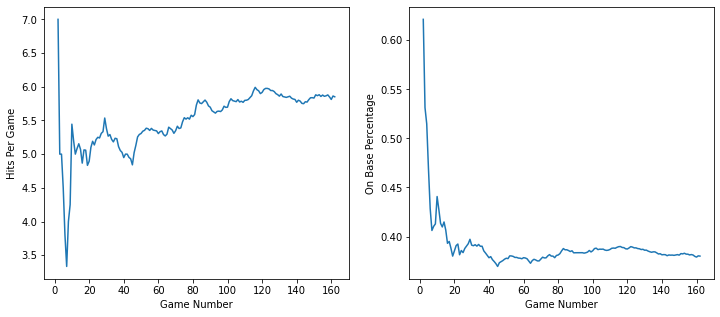

In [17]:
yankees_data = team_data[team_data['Team'] == 'New York Yankees']
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(yankees_data['GameNum'], yankees_data['Runs_Mean'])
axes[0].set_xlabel('Game Number')
axes[0].set_ylabel('Hits Per Game')
axes[1].plot(yankees_data['GameNum'], yankees_data['OBP_Mean'])
axes[1].set_xlabel('Game Number')
axes[1].set_ylabel('On Base Percentage')

In [18]:
team_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4858 entries, 0 to 633
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GameID         4858 non-null   int64   
 1   Team           4858 non-null   category
 2   GameNum        4858 non-null   int64   
 3   HomeAway       4858 non-null   category
 4   Runs           4858 non-null   int64   
 5   Hits           4858 non-null   int64   
 6   Errors         4858 non-null   int64   
 7   AB             4858 non-null   int64   
 8   RBI            4858 non-null   int64   
 9   BB             4858 non-null   int64   
 10  SO             4858 non-null   int64   
 11  PA             4858 non-null   int64   
 12  OBP            4858 non-null   float64 
 13  SLG            4858 non-null   float64 
 14  Starter        4858 non-null   category
 15  OBP_NUM        4858 non-null   float64 
 16  SLG_NUM        4858 non-null   float64 
 17  Runs_Mean      4828 non-null   flo

We have two more years worth of data but we've written a function to automate this data cleaning workflow for us. Let's apply that to the data from 2017 and 2018. We'll actually be using the 2019 data as our test data set and 2017/2018 for trainig.

In [19]:
# Import 2018 data
parsed18 = pkl.load(open(os.path.join(parentDirectory, 'data', 'parsedData2018.p'), 'rb'))
game_level18 = parsed18['Game']
team_level18 = parsed18['Team']

# Import 2017 data
parsed17 = pkl.load(open(os.path.join(parentDirectory, 'data', 'parsedData2018.p'), 'rb'))
game_level17 = parsed17['Game']
team_level17 = parsed17['Team']

# Clean data
model_data18 = clean_data.clean_season_data(team_level18, game_level18)
model_data17 = clean_data.clean_season_data(team_level17, game_level17)

# Join 2017 and 2018 data and label train and test sets
train = pd.concat([model_data18, model_data17])
test = team_data

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9724 entries, 0 to 1524
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GameID         9724 non-null   int64   
 1   Team           9724 non-null   category
 2   GameNum        9724 non-null   int64   
 3   HomeAway       9724 non-null   category
 4   Runs           9724 non-null   int64   
 5   Hits           9724 non-null   int64   
 6   Errors         9724 non-null   int64   
 7   AB             9724 non-null   int64   
 8   RBI            9724 non-null   int64   
 9   BB             9724 non-null   int64   
 10  SO             9724 non-null   int64   
 11  PA             9724 non-null   int64   
 12  OBP            9724 non-null   float64 
 13  SLG            9724 non-null   float64 
 14  Starter        9724 non-null   category
 15  OBP_NUM        9724 non-null   float64 
 16  SLG_NUM        9724 non-null   float64 
 17  Runs_Mean      9664 non-null   fl

## Data Exploration and Feature Selection

Now that we have all of the data we will use for our model let's explore it a little bit. There are many columns in the DataFrame above and we won't use all of them, so let's isolate the columns we want to explore more, separating them into numerical and categorical variables.

In [21]:
numerical_vars = ['Runs_Mean', 'Hits_Mean', 'Errors_Mean', 'RBI_Mean', 'BB_Mean', 'SO_Mean', 'SLG_Mean', 'OBP_Mean', 'Runs']
categorical_vars = ['HomeAway']

Since it takes a few games for the averages to stabilize we'll remove the first 10 games from each season. Notice that we no longer have any null-values anymore.

In [22]:
train = train[train['GameNum'] > 10]
test = test[test['GameNum'] > 10]

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9124 entries, 344 to 1524
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GameID         9124 non-null   int64   
 1   Team           9124 non-null   category
 2   GameNum        9124 non-null   int64   
 3   HomeAway       9124 non-null   category
 4   Runs           9124 non-null   int64   
 5   Hits           9124 non-null   int64   
 6   Errors         9124 non-null   int64   
 7   AB             9124 non-null   int64   
 8   RBI            9124 non-null   int64   
 9   BB             9124 non-null   int64   
 10  SO             9124 non-null   int64   
 11  PA             9124 non-null   int64   
 12  OBP            9124 non-null   float64 
 13  SLG            9124 non-null   float64 
 14  Starter        9124 non-null   category
 15  OBP_NUM        9124 non-null   float64 
 16  SLG_NUM        9124 non-null   float64 
 17  Runs_Mean      9124 non-null   

In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4558 entries, 2575 to 633
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GameID         4558 non-null   int64   
 1   Team           4558 non-null   category
 2   GameNum        4558 non-null   int64   
 3   HomeAway       4558 non-null   category
 4   Runs           4558 non-null   int64   
 5   Hits           4558 non-null   int64   
 6   Errors         4558 non-null   int64   
 7   AB             4558 non-null   int64   
 8   RBI            4558 non-null   int64   
 9   BB             4558 non-null   int64   
 10  SO             4558 non-null   int64   
 11  PA             4558 non-null   int64   
 12  OBP            4558 non-null   float64 
 13  SLG            4558 non-null   float64 
 14  Starter        4558 non-null   category
 15  OBP_NUM        4558 non-null   float64 
 16  SLG_NUM        4558 non-null   float64 
 17  Runs_Mean      4558 non-null   

Let's look at the correlation matrix of the numerical columns.

In [25]:
train[numerical_vars].corr()

,Runs_Mean,Hits_Mean,Errors_Mean,RBI_Mean,BB_Mean,SO_Mean,SLG_Mean,OBP_Mean,Runs
Runs_Mean,1.000000,0.664741,-0.119569,0.993616,0.519330,-0.305816,0.801165,0.797799,0.073651
Hits_Mean,0.664741,1.000000,-0.139673,0.647632,-0.001666,-0.565792,0.707325,0.614857,0.028651
Errors_Mean,-0.119569,-0.139673,1.000000,-0.104447,0.022448,0.448236,-0.128166,-0.054399,-0.011047
RBI_Mean,0.993616,0.647632,-0.104447,1.000000,0.516857,-0.290765,0.809158,0.784974,0.072198
BB_Mean,0.519330,-0.001666,0.022448,0.516857,1.000000,0.185592,0.064102,0.728892,0.059284
SO_Mean,-0.305816,-0.565792,0.448236,-0.290765,0.185592,1.000000,-0.373032,-0.258032,-0.024189
SLG_Mean,0.801165,0.707325,-0.128166,0.809158,0.064102,-0.373032,1.000000,0.481215,0.062675
OBP_Mean,0.797799,0.614857,-0.054399,0.784974,0.728892,-0.258032,0.481215,1.000000,0.061271
Runs,0.073651,0.028651,-0.011047,0.072198,0.059284,-0.024189,0.062675,0.061271,1.000000


Let's convert the home/away variable into dummy variables.

In [26]:
train_dummies = pd.get_dummies(train[categorical_vars]).drop(columns=['HomeAway_Away'])
train = pd.concat([train, train_dummies], axis=1)

test_dummies = pd.get_dummies(test[categorical_vars]).drop(columns=['HomeAway_Away'])
test = pd.concat([test, test_dummies], axis=1)

## Model Selection
### Linear Regression
We'll begin by fitting a linear regression model using Recursive Feature Elimination.

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

predictors = numerical_vars[:-1] + ['HomeAway_Home']

# Create cross validator
kfolds = KFold(n_splits=10, random_state=1988, shuffle=True)

# Define estimator
lm = LinearRegression()

# Create and fit selector
selector = RFECV(lm, cv=kfolds, scoring='neg_mean_squared_error')
selector.fit(train[predictors], train['Runs'])
lm_best_predictors = train[predictors].columns[selector.support_]
print(lm_best_predictors)

# Extract model
lm_best = selector.estimator_

Index(['Runs_Mean', 'Hits_Mean', 'Errors_Mean', 'RBI_Mean', 'BB_Mean',
       'SO_Mean', 'SLG_Mean', 'HomeAway_Home'],
      dtype='object')


We'll now evaluate this on the test set and save the mean squared error.

In [38]:
from sklearn.metrics import mean_squared_error
mses = {}
predictions = lm_best.predict(test[lm_best_predictors])
mses['Linear Regression'] = mean_squared_error(predictions, test['Runs'])
print('The root MSE for Linear Regression is %f' % np.sqrt(mses['Linear Regression']))

The root MSE for Linear Regression is 3.315082
